In [1]:
import numpy as np 
from scipy import linalg
import matplotlib.pyplot as plt
from scipy import interpolate

In [183]:
def upwelling_radiation(j, emissivities):
    emissivities_for_each_layer = []
    for l in range(j, -1, -1):
        #emmisivity of layer j
        E_j = emissivities[j] 
        
        # emmisivity of source layer (index j minus l minus one)
        if j-l-1 == -1:
            E_jmlm1 = 0.0 
        else:
            E_jmlm1 = emissivities[j-l-1]

        # For layers that are not j or source, find effective emmisivity after absorption 
        effective_emissivity_of_transmission_layers = []
        for k in range(j-l, j):
            fraction_of_emissivity_transfered = 1 - (emissivities[k])
            effective_emissivity_of_transmission_layers.append(fraction_of_emissivity_transfered)
         
        # Multiply all the effective emissivities of transmission layers, to get one final effective emissivity
        if len(effective_emissivity_of_transmission_layers) == 0:
            product_of_transmission_layers = 1
        elif len(effective_emissivity_of_transmission_layers) > 0:
            product_of_transmission_layers = np.prod(effective_emissivity_of_transmission_layers)
            
        #Now multiply the source and reciving layers by the effective emissivity of the transmission layers
        total_emissivity_product = E_j*E_jmlm1*product_of_transmission_layers
        emissivities_for_each_layer.append(total_emissivity_product)
        
    # return the emissivities of each layer now, but take out first entry which is always zero
    return(emissivities_for_each_layer[1:])


def R_up_matrix(N, emissivities):
    empty_Np1_Np1_array = np.zeros((N+1,N+1))
    # We need to change elements of array based off the row 
    for j in range(0, N+1):
        row_to_change = empty_Np1_Np1_array[j]
        
        # Find emissivities associated with upwelling radiation
        upwelling_terms = upwelling_radiation(j, emissivities)
        
        # Diagonal elements should still remain zero, we will deal with this later
        if len(upwelling_terms) == 0:
            continue
        
        elif len(upwelling_terms) > 0:
            # Here we will change each element in our matrix that corresponds to upwelling radiation
            # In the end, this will only make us have a lower triangular matrix with a diagonal of zero
            for upwelling_idx, upwelling_emissivity in enumerate(upwelling_terms):
                row_to_change[upwelling_idx] = upwelling_emissivity
            row_of_upwelling_radiation = row_to_change
                
        # After the row is changed to the upwelling values, put this row into our matrix
        empty_Np1_Np1_array[j] = row_of_upwelling_radiation
    
    # Now we have an upwelling radiation matrix, which has a zero diagonal and is lower triangular!
    upwelling_radiation_matrix = np.matrix(empty_Np1_Np1_array)
    return(upwelling_radiation_matrix)
    
    
def emissivity_matrix(R_up_matrix, emissivities):
    # downwelling radiation matrix is transpose of upwelling
    R_down_matrix = R_up_matrix.T
    
    # The sum of the upwelling and downwelling radiation is the recieved radiation matrix
    # This matrix does not account for the emitted radiation of each layer, or the forcings
    recieved_radiation_matrix = R_up_matrix + R_down_matrix
    
    # We need to add in the diagonal to the recieved radiation matrix, the diagonal accounts for emitted
    # radiation of each layer, it should have opposite sign than recieved radiation.
    # Unbounded layers eminate both up and down, so all layers besides surface should be multiplied by 2.
    emissivities_diagonal = -2*np.diag(emissivities)
    emissivities_diagonal[0][0] = -1
    
    # total emissivity matrix will be sum of both radiation recieved and radiation emmitted! 
    emissivity_matrix = recieved_radiation_matrix + emissivities_diagonal
    return(emissivity_matrix)

def vertical_heat_flux_profile(N, total_vertical_heat_flux, profile_type):
    number_of_layers = N+1
    # Stratosphere will be only radiatively coupled, so only have heatflux for bottom 85% of layers
    number_of_layers_w_heat_flux = int(number_of_layers*0.85)
    
    if profile_type == 'linear':
        ##### VTC EDIT ####
        linearly_decreasing_heat_flux = np.linspace(1, 0, number_of_layers_w_heat_flux-1)
        linearly_decreasing_heat_flux = np.append(np.array([1]),linearly_decreasing_heat_flux)
        ##### end EDIT ####
        normalized_linear_decreasing_heat_flux = linearly_decreasing_heat_flux/np.sum(linearly_decreasing_heat_flux)

        # Now we can create the heat flux profile which spans the first 85% of layers and sums to total heat flux
        actual_lin_dec_heat_flux_profile = normalized_linear_decreasing_heat_flux*total_vertical_heat_flux
        total_atmospheric_heatflux_profile = np.zeros(number_of_layers)

        total_atmospheric_heatflux_profile[:number_of_layers_w_heat_flux] = actual_lin_dec_heat_flux_profile
        #downward_flux = np.insert(total_atmospheric_heatflux_profile[:-1], 0, 0)
        return(total_atmospheric_heatflux_profile)#, downward_flux)
    elif profile_type == 'exponential':
        ##### VTC EDIT ####
        exponentially_decreasing_heat_flux = np.geomspace(1, 1e-5, number_of_layers_w_heat_flux-1)
        exponentially_decreasing_heat_flux = np.append(np.array([1]),exponentially_decreasing_heat_flux)
        ##### end EDIT ####
        normalized_exp_decreasing_heat_flux = exponentially_decreasing_heat_flux/np.sum(exponentially_decreasing_heat_flux)

        # Now we can create the heat flux profile which spans the first 85% of layers and sums to total heat flux
        actual_exp_dec_heat_flux_profile = normalized_exp_decreasing_heat_flux*total_vertical_heat_flux
        total_atmospheric_heatflux_profile = np.zeros(number_of_layers)

        total_atmospheric_heatflux_profile[:number_of_layers_w_heat_flux] = actual_exp_dec_heat_flux_profile
        #downward_flux = np.insert(total_atmospheric_heatflux_profile[:-1], 0, 0)
        return(total_atmospheric_heatflux_profile)#, downward_flux)
    
    
#### NEW VERSION OF VERT ###
def vertical_heat_flux_profile(N, total_vertical_heat_flux, profile_type):
    number_of_layers = N+1
    # Stratosphere will be only radiatively coupled, so only have heatflux for bottom 85% of layers
    number_of_layers_w_heat_flux = int(number_of_layers*0.85) - 1
    ## VTC added -1 ###
    
    if profile_type == 'linear':
        linearly_decreasing_heat_flux = np.linspace(1, 0, number_of_layers_w_heat_flux)
        normalized_linear_decreasing_heat_flux = linearly_decreasing_heat_flux/np.sum(linearly_decreasing_heat_flux)

        # Now we can create the heat flux profile which spans the first 85% of layers and sums to total heat flux
        actual_lin_dec_heat_flux_profile = normalized_linear_decreasing_heat_flux*total_vertical_heat_flux
        
        ### VTC edits ###
        ## net of incoming from layer below, starting from 1st atmos layer ##
        actual_lin_dec_heat_flux_profile[1:] -= actual_lin_dec_heat_flux_profile[:-1]
        #################
        
        total_atmospheric_heatflux_profile = np.zeros(number_of_layers)

        total_atmospheric_heatflux_profile[:number_of_layers_w_heat_flux] = actual_lin_dec_heat_flux_profile
        #downward_flux = np.insert(total_atmospheric_heatflux_profile[:-1], 0, 0)
        return(total_atmospheric_heatflux_profile)#, downward_flux)
    elif profile_type == 'exponential':
        exponentially_decreasing_heat_flux = np.geomspace(1, 1e-5, number_of_layers_w_heat_flux)
        normalized_exp_decreasing_heat_flux = exponentially_decreasing_heat_flux/np.sum(exponentially_decreasing_heat_flux)

        # Now we can create the heat flux profile which spans the first 85% of layers and sums to total heat flux
        actual_exp_dec_heat_flux_profile = normalized_exp_decreasing_heat_flux*total_vertical_heat_flux
        
        ### VTC edits ###
        ## net of incoming from layer below, starting from 1st atmos layer ##
        actual_exp_dec_heat_flux_profile[1:] -= actual_exp_dec_heat_flux_profile[:-1]
        #################
        
        total_atmospheric_heatflux_profile = np.zeros(number_of_layers)

        total_atmospheric_heatflux_profile[:number_of_layers_w_heat_flux] = actual_exp_dec_heat_flux_profile
        return(total_atmospheric_heatflux_profile)
    
    elif profile_type == 'tanh':
        xx = np.flip(np.linspace(0,np.pi,number_of_layers_w_heat_flux) - np.pi)
        yy = np.tanh(xx) + 1
        normalized_tanh_decreasing_heat_flux = yy/yy.sum()
        
        # Now we can create the heat flux profile which spans the first 85% of layers and sums to total heat flux
        actual_tanh_dec_heat_flux_profile = normalized_tanh_decreasing_heat_flux*total_vertical_heat_flux
        
        ### VTC edits ###
        ## net of incoming from layer below, starting from 1st atmos layer ##
        actual_tanh_dec_heat_flux_profile[1:] -= actual_tanh_dec_heat_flux_profile[:-1]
        #################
        
        total_atmospheric_heatflux_profile = np.zeros(number_of_layers)

        total_atmospheric_heatflux_profile[:number_of_layers_w_heat_flux] = actual_tanh_dec_heat_flux_profile
        return(total_atmospheric_heatflux_profile)
    

def forcings_vector(N, insolation, heat_flux_profile):
    # Let all the forcings be zero for now, besides the insolation
    forcings = np.zeros(N+1)
    forcings[0] = insolation*-1
    net_forcings = forcings + heat_flux_profile
    
    
    # Forcings should also be scaled by 1/sigma
    sigma = 5.67e-8 # W * m^-2 * K^-4
    
    one_over_sigma = 1/sigma
    
    return(net_forcings*one_over_sigma)

def temperature(total_emissivity_matrix, forcings):
    """
    We have an matrix equation of (total_emissivity_matrix) X (T_i^4) = F_i
    Where total emissivity matrix is N+1 x N+1, T_i^4 is a column vector of N+1 and 
    forcings are another column vector, scaled by 1/sigma.
    """
    
    inverse_of_emissivity_matrix = linalg.inv(total_emissivity_matrix)
    temperature_vector = forcings.dot(inverse_of_emissivity_matrix)
    return(np.array(temperature_vector)**(1/4))

1.0000000000000002
0.9999999999999999


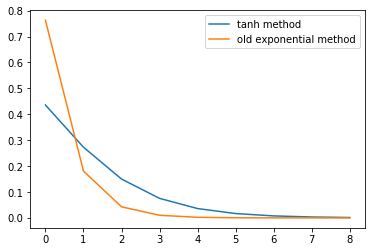

In [182]:
## hyberbolic tangent weighting
number_of_layers_w_heat_flux = int(self_N*0.85) - 1
xx = np.flip(np.linspace(0,np.pi,number_of_layers_w_heat_flux) - np.pi)
yy = np.tanh(xx) + 1
yy_normalized = yy/yy.sum()
plt.plot(yy_normalized,label='tanh method')
print(yy_normalized.sum())

plt.plot(temp_normalized_exp_decreasing_heat_flux,label='old exponential method')
print(temp_normalized_exp_decreasing_heat_flux.sum())
plt.legend()

0.9999999999999999


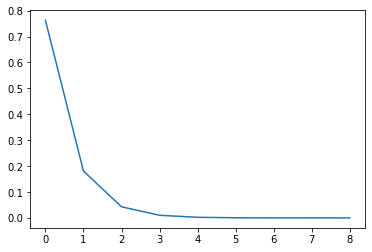

In [102]:
temp_exponentially_decreasing_heat_flux = np.geomspace(1, 1e-5, number_of_layers_w_heat_flux)
temp_normalized_exp_decreasing_heat_flux = temp_exponentially_decreasing_heat_flux/np.sum(temp_exponentially_decreasing_heat_flux)
plt.plot(temp_normalized_exp_decreasing_heat_flux)
print(temp_normalized_exp_decreasing_heat_flux.sum())

In [3]:
number_of_layers = N+1
number_of_layers_w_heat_flux = int((self_N+1)*0.85)
    
profile_type = 'exponential'
total_vertical_heat_flux = 110
if profile_type == 'linear':
    linearly_decreasing_heat_flux = np.linspace(1, 0, number_of_layers_w_heat_flux-1)
    linearly_decreasing_heat_flux = np.append(np.array([1]),linearly_decreasing_heat_flux)
    normalized_linear_decreasing_heat_flux = linearly_decreasing_heat_flux/np.sum(linearly_decreasing_heat_flux)

    # Now we can create the heat flux profile which spans the first 85% of layers and sums to total heat flux
    actual_lin_dec_heat_flux_profile = normalized_linear_decreasing_heat_flux*total_vertical_heat_flux
    total_atmospheric_heatflux_profile = np.zeros(number_of_layers)

    total_atmospheric_heatflux_profile[:number_of_layers_w_heat_flux] = actual_lin_dec_heat_flux_profile
    #downward_flux = np.insert(total_atmospheric_heatflux_profile[:-1], 0, 0)
    print(total_atmospheric_heatflux_profile)
elif profile_type == 'exponential':
    exponentially_decreasing_heat_flux = np.geomspace(1, 1e-5, number_of_layers_w_heat_flux-1)
    exponentially_decreasing_heat_flux = np.append(np.array([1]),exponentially_decreasing_heat_flux)
    normalized_exp_decreasing_heat_flux = exponentially_decreasing_heat_flux/np.sum(exponentially_decreasing_heat_flux)

    # Now we can create the heat flux profile which spans the first 85% of layers and sums to total heat flux
    actual_exp_dec_heat_flux_profile = normalized_exp_decreasing_heat_flux*total_vertical_heat_flux
    total_atmospheric_heatflux_profile = np.zeros(number_of_layers)

    total_atmospheric_heatflux_profile[:number_of_layers_w_heat_flux] = actual_exp_dec_heat_flux_profile
    #downward_flux = np.insert(total_atmospheric_heatflux_profile[:-1], 0, 0)
    print(total_atmospheric_heatflux_profile)

print(N_tpause_location)

NameError: name 'N' is not defined

In [ ]:
def __init__(self):
        """
        
        Collect scalable physical parameters to be used for the N-Layer radiative model.
        
        """
        self.N_slider = widgets.IntSlider(min=1, max=100, value=2, description='N-Layers: ')
        widgets.interact(self.get_n_slider, N_slider=self.N_slider)
        
        self.albedo_slider = widgets.FloatSlider(min=0, max=1, value=0.3, description='Albedo: ')
        widgets.interact(self.get_albedo_slider, albedo_slider=self.albedo_slider)
        
        self.S0_slider = widgets.IntSlider(min=10, max=10000, value=1368, description='$S_{0}$ ($W/m^2$): ')
        widgets.interact(self.get_S0_slider, S0_slider=self.S0_slider)
        
        self.heatflux_slider = widgets.IntSlider(min=10, max=1000, value=110, 
                                                 description='Heat Flux \nTotal ($W/m^2$): ')
        widgets.interact(self.get_heatflux_slider, heatflux_slider=self.heatflux_slider)
        
        #self.pertub_button = widgets.ToggleButton(value=False, description='Perturbation?',
        #                                         disabled=False, button_style='info',
        #                                         tooltip='Description')
        #widgets.interact(self.get_perturbation, calc_button=self.pertub_button)
        
        self.calc_button = widgets.ToggleButton(value=False, description='Radiate',
                                                 disabled=False, button_style='info',
                                                 tooltip='Description')
        widgets.interact(self.get_temps, calc_button=self.calc_button)

In [186]:
#### THIS GOES INTO UTILS ####
def forcings_vector(N, insolation, heat_flux_profile, SW_stratosphere_absorption):
    # Let all the forcings be zero for now, besides the insolation
    forcings = np.zeros(N+1)
    
    ### VTC EDIT ###
    forcings[0] = insolation*-1 + SW_stratosphere_absorption
    N_troposphere = np.floor(0.85*N) - 1 ## subtract 1 to allow for tropopause
    N_tpause = 1 ## 1 layer is the tropopause
    N_tpause_location = int(0.85*N) # layer number for the tropopause, with 0 layer as surface
    N_stratosphere = N - N_troposphere - N_tpause
    
    # stratospheric forcing will be spread uniformly over each strat layer
    forcings[N_tpause_location+1:] = -SW_stratosphere_absorption / N_stratosphere
    ### end edit ###
    
    net_forcings = forcings + heat_flux_profile
    
    # Forcings should also be scaled by 1/sigma
    sigma = 5.67e-8 # W * m^-2 * K^-4
    
    one_over_sigma = 1/sigma
    
    return(net_forcings*one_over_sigma)

In [106]:
#    temp_forcings = forcings_vector(N, insolation, temp_upward_heatflux, sw_upper)
print(temp_forcings[0]*5.67e-8)
print(-(insolation - sw_upper + temp_upward_heatflux[0])) # wrong, current
print(-(insolation - sw_upper - temp_upward_heatflux[0])) # corrected
temp_upward_heatflux 

-165.6263460089076
-292.65365399109237
-165.6263460089076


array([ 6.35136540e+01, -4.58406025e+01, -1.27554199e+01, -3.54927137e+00,
       -9.87605842e-01, -2.74807192e-01, -7.64667336e-02, -2.12773229e-02,
       -5.92054148e-03, -1.64742584e-03,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00])

In [219]:
N = 12

self_S0 = 1368
sw_upper = 1*0.03 * self_S0/4 # https://www.e-education.psu.edu/meteo300/node/649, 3% absorbed in Stratosphere

self_albedo = 0.3
self_heatflux = 3*110
self_N = N

insolation = (self_S0/4)*(1 - self_albedo)

#### THIS GOES INTO GET_TEMPS ####
## separate N into troposphere, tropopause, and stratosphere
N_troposphere = int(0.85*N) - 1 ## subtract 1 to allow for tropopause
N_tpause = 1 ## 1 layer is the tropical tropoause layer
N_tpause_location = int(0.85*N) # layer number for the TTL, including surface as zero index
N_stratosphere = N - N_troposphere - N_tpause
print(N_troposphere, N_tpause, N_stratosphere, N_stratosphere + N_troposphere + N_tpause - N)

### M realizations of possible emmisivity profiles for mr. monte carlo
M = 10000

### emissivity profile for each layer
emissivity_surface_M = np.tile(1,M)

## monotonic decreasing emissivities in troposphere
## this selects a random first layer emissivity,
## then each higher layer is random, but a lesser emissivity than the layer below it
emissivity_troposphere_M = np.zeros((M,N_troposphere))
emissivity_troposphere_M[:,0] = np.random.uniform(0.2,1,M)
for i in range(N_troposphere-1):
    emissivity_troposphere_M[:,i+1] = np.random.uniform(0.001,
                                                        emissivity_troposphere_M[:,i],M)

## tropopause
emissivity_tpause_M = np.random.uniform(0.0001,emissivity_troposphere_M[:,-1],M)

## stratosphere
emissivity_stratosphere_M = np.zeros((M,N_stratosphere))
emissivity_stratosphere_M[:,0] = np.random.uniform(0.00001,emissivity_tpause_M,M)
for i in range(N_stratosphere-1):
    emissivity_stratosphere_M[:,i+1] = np.random.uniform(0,
                                                         emissivity_stratosphere_M[:,i],M)
# emissivity_stratosphere_M = np.random.uniform(0.0001,
#                                               np.repeat(emissivity_tpause_M[:,np.newaxis],N_stratosphere,axis=1),
#                                               (M,N_stratosphere))

emissivity_Nlayers_M = np.vstack([emissivity_surface_M,
                                  emissivity_troposphere_M.T,
                                  emissivity_tpause_M,
                                  emissivity_stratosphere_M.T])

# ## placeholder for temps
# layer_temps_N = np.zeros([layers_N.shape[0]+1, ## add surface temp layer
#                          layers_N.shape[1]])

9 1 2 0


171


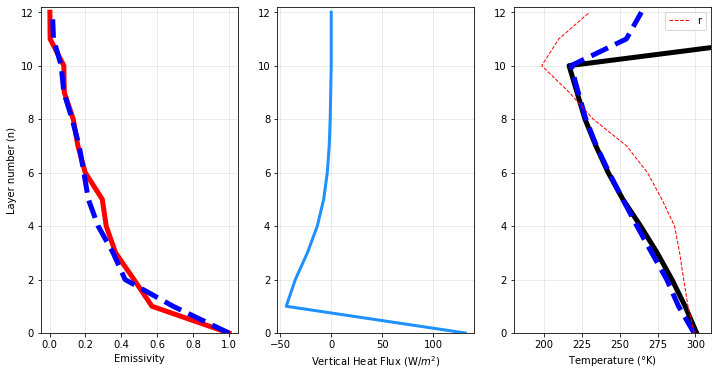

CPU times: user 11 s, sys: 51.8 ms, total: 11.1 s
Wall time: 11.1 s


In [220]:
%%time
# arrays to hold Monte Carlo values
temperature_M = np.zeros([M,N+1]) # arrays to hold Monte Carlo values

fig, axs = plt.subplots(1,3, figsize=(12,6))
for i,val in enumerate(emissivity_Nlayers_M.T):
#     val = emissivities
    temp_R_up_matrix = R_up_matrix(N, val)
    temp_total_emissivity_matrix = emissivity_matrix(temp_R_up_matrix, val)
            
    temp_upward_heatflux = vertical_heat_flux_profile(N, self_heatflux, 'tanh')
            
#     forcings = utils.forcings_vector(self.N, insolation, upward_heatflux)
    temp_forcings = forcings_vector(N, insolation, temp_upward_heatflux, sw_upper)
            
           

    # Now find the temperature vector using the emissivity matrix and the forcings
    temp_temperature_vector = temperature(temp_total_emissivity_matrix, temp_forcings)
    temperature_M[i] = temp_temperature_vector
    
    

    # Emissivities plot
#     axs[0].plot(val, range(0, self_N+1), color='black',alpha=0.01)
#     axs[2].plot(temp_temperature_vector, range(0, self_N+1), color='firebrick', linewidth=3,alpha=0.01)

## selecting the best profile
era5_profile = np.load('tropical_profile.npy')
# era5_profile = np.load('polar_profile.npy')
#         elif self.togglebutton == 'Poles':
#             era5_profile = np.load('polar_profile.npy')
        
era5_N_of_tpause = np.where(np.r_[True, era5_profile[1:] < era5_profile[:-1]] & 
                                np.r_[era5_profile[:-1] < era5_profile[1:], True])[0][0]

era5_layers = np.linspace(0, self_N, 32)
era5_layers_to_tpause = np.linspace(0, N_tpause_location, era5_N_of_tpause)
interp_troposphere = interpolate.interp1d(era5_layers_to_tpause, era5_profile[:era5_N_of_tpause])
profile_for_emissivities_trop = interp_troposphere(np.arange(N_tpause_location+1))

interp_stratosphere = interpolate.interp1d(era5_layers[era5_N_of_tpause:], era5_profile[era5_N_of_tpause:])
profile_for_emissivities_strat = interp_stratosphere(np.arange(N_stratosphere) + N_tpause_location + 1)
profile_for_emissivities_all = np.append(profile_for_emissivities_trop, profile_for_emissivities_strat)

## restrict to accurate surface temperature
## this is a dummy that places -1000 as the surface temp for anything that is
## more than 2 degrees off the surface temperature.
temperature_M_temp = temperature_M.copy()
temperature_M_temp[:,0] = np.where(
    np.abs(profile_for_emissivities_trop[0] - temperature_M[:,0]) < 2, 
    temperature_M[:,0], 
    -1000)
print(np.where(
    np.abs(profile_for_emissivities_trop[0] - temperature_M[:,0]) < 2, 
    1,0).sum())

## find profile that minimizes the squared error relative to era5, only up to the tropopause
error = ((temperature_M_temp[:,:N_tpause_location+1] - profile_for_emissivities_trop)**2).sum(axis=1)
np.where(error == error.min())
best_index = np.where(error == error.min())   

partition_ind = np.argpartition(error,10)

## now include stratosphere in error calc
error = ((temperature_M_temp - profile_for_emissivities_all)**2).sum(axis=1)
# error += (temperature_M_temp[:,-1] - temperature_M_temp[:,N_tpause_location]) - (
#     (profile_for_emissivities_all[-1] - profile_for_emissivities_all[N_tpause_location]))**2
np.where(error == error.min())
best_index_all = np.where(error == error.min())



# Emissivities plot
axs[0].plot(emissivity_Nlayers_M[:,best_index].squeeze(), 
            np.arange(self_N+1), color='r', linewidth=5,alpha=1)
axs[0].plot(emissivity_Nlayers_M[:,best_index_all].squeeze(), 
            np.arange(self_N+1), color='b', linewidth=5,alpha=1, ls='--')
axs[0].set_ylabel('Layer number (n)')
axs[0].set_xlabel('Emissivity')
axs[0].set_ylim(0,self_N+0.2)
axs[0].grid(alpha=0.3)

axs[1].set_xlabel('Vertical Heat Flux (W/$m^2$)')
axs[1].plot(temp_upward_heatflux, np.arange(self_N+1), color='dodgerblue',alpha=1,lw=3)
axs[1].set_ylim(0,self_N+0.2)
axs[1].grid(alpha=0.3)

axs[2].plot(temperature_M[best_index].squeeze(), 
            np.arange(self_N+1), color='k', linewidth=5,alpha=1)
axs[2].plot(temperature_M[best_index_all].squeeze(), 
            np.arange(self_N+1), color='b', ls='--',linewidth=5,alpha=1)
plt.plot(profile_for_emissivities_all,
         np.arange(len(profile_for_emissivities_all)),
         c='r',ls='--',lw=1,label='r')
axs[2].set_xlabel('Temperature ($\degree$K)')
axs[2].set_ylim(0,self_N+0.2)
axs[2].set_xlim(180,310)
axs[2].grid(alpha=0.3)
axs[2].legend()

plt.show()

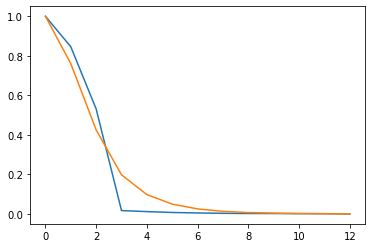

In [192]:
plt.plot(emissivity_Nlayers_M[:,best_index[0]])
plt.plot((emissivity_Nlayers_M[:,partition_ind[:k]]).mean(axis=1))

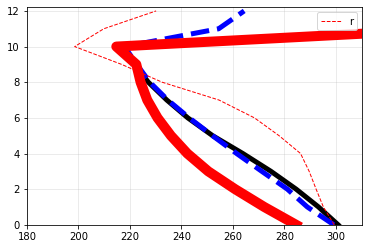

In [221]:
val = (emissivity_Nlayers_M[:,partition_ind[:k]]).mean(axis=1)
temp_R_up_matrix = R_up_matrix(N, val)
temp_total_emissivity_matrix = emissivity_matrix(temp_R_up_matrix, val)

temp_upward_heatflux = vertical_heat_flux_profile(N, self_heatflux, 'tanh')

#     forcings = utils.forcings_vector(self.N, insolation, upward_heatflux)
temp_forcings = forcings_vector(N, insolation, temp_upward_heatflux, sw_upper)



# Now find the temperature vector using the emissivity matrix and the forcings
temp_temperature_vector = temperature(temp_total_emissivity_matrix, temp_forcings)
plt.plot(temperature_M[best_index].squeeze(), 
            np.arange(self_N+1), color='k', linewidth=5,alpha=1)
plt.plot(temperature_M[best_index_all].squeeze(), 
            np.arange(self_N+1), color='b', ls='--',linewidth=5,alpha=1)
plt.plot(profile_for_emissivities_all,
         np.arange(len(profile_for_emissivities_all)),
         c='r',ls='--',lw=1,label='r')
plt.plot(temp_temperature_vector,np.arange(len(profile_for_emissivities_all)),
         c='r',lw=10)
plt.ylim(0,self_N+0.2)
plt.xlim(180,310)
plt.grid(alpha=0.3)
plt.legend()

plt.show()

In [199]:
temp_temperature_vector

array([297.41858914, 267.44074988, 244.96705122, 233.73395021,
       228.66168925, 226.04221018, 224.52488773, 223.61370177,
       222.68806327, 221.32510485, 214.4588214 , 461.82750382,
       538.09661252])

(13, 2)
(13, 500)
(13, 500)


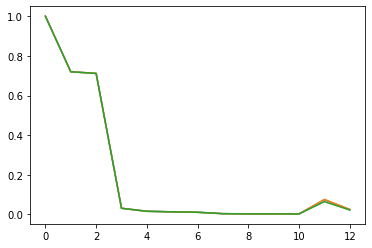

In [170]:
k = 2
partition_ind = np.argpartition(error,k)
print((emissivity_Nlayers_M[:,partition_ind[:k]]).shape)
plt.plot((emissivity_Nlayers_M[:,partition_ind[:k]]).mean(axis=1))

k = 500
partition_ind = np.argpartition(error,k)
print((emissivity_Nlayers_M[:,partition_ind[:k]]).shape)
plt.plot((emissivity_Nlayers_M[:,partition_ind[:k]]).mean(axis=1))

k = 500
partition_ind = np.argpartition(error,k)
print((emissivity_Nlayers_M[:,partition_ind[:k]]).shape)
plt.plot((emissivity_Nlayers_M[:,partition_ind[:k]])[:,7])

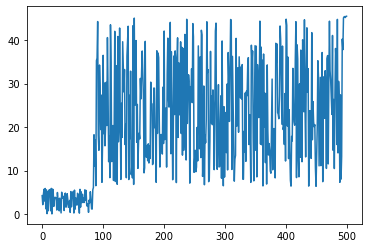

In [165]:
plt.plot(error[partition_ind[:k]])
# emissivity_Nlayers_M[:,partition_ind[:k]].shape

3465


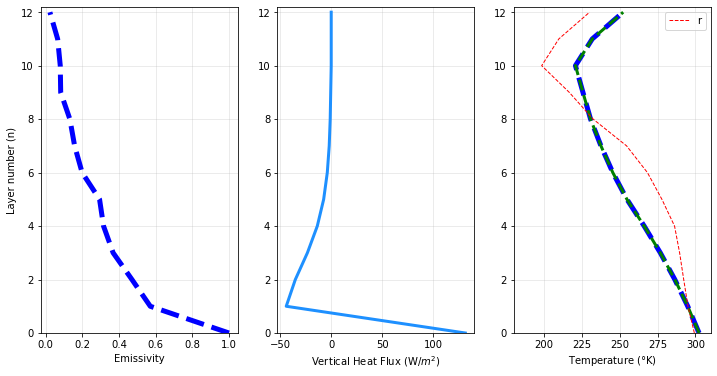

CPU times: user 11.3 s, sys: 55.9 ms, total: 11.3 s
Wall time: 11.3 s


In [222]:
%%time
### additional MC for stratosphere
## start with best fit for tropopause
emissivity_Nlayers_M = np.repeat(emissivity_Nlayers_M[:,best_index[0]],M,axis=1)

emissivity_tpause = emissivity_Nlayers_M[:,best_index[0]][N_tpause_location]

## stratosphere: resample possible strat values
emissivity_stratosphere_M = np.zeros((M,N_stratosphere))
emissivity_stratosphere_M[:,0] = np.random.uniform(0.000001,emissivity_tpause,M)
emissivity_stratosphere_M[:,0] = np.random.uniform(0.000001,0.1,M)
for i in range(N_stratosphere-1):
#     emissivity_stratosphere_M[:,i+1] = np.random.uniform(0,emissivity_stratosphere_M[:,i]*10,M)
    emissivity_stratosphere_M[:,i+1] = np.random.uniform(0,0.1,M)

emissivity_Nlayers_M = np.vstack([emissivity_Nlayers_M[:N_tpause_location+1],
                                  emissivity_stratosphere_M.T])

# arrays to hold Monte Carlo values
temperature_M = np.zeros([M,N+1]) # arrays to hold Monte Carlo values

fig, axs = plt.subplots(1,3, figsize=(12,6))
for i,val in enumerate(emissivity_Nlayers_M.T):
    temp_R_up_matrix = R_up_matrix(N, val)
    temp_total_emissivity_matrix = emissivity_matrix(temp_R_up_matrix, val)
            
    temp_upward_heatflux = vertical_heat_flux_profile(N, self_heatflux, 'tanh')
            
#     forcings = utils.forcings_vector(self.N, insolation, upward_heatflux)
    temp_forcings = forcings_vector(N, insolation, temp_upward_heatflux, sw_upper)
            
           

    # Now find the temperature vector using the emissivity matrix and the forcings
    temp_temperature_vector = temperature(temp_total_emissivity_matrix, temp_forcings)
    temperature_M[i] = temp_temperature_vector

## restrict to accurate surface temperature
## this is a dummy that places -1000 as the surface temp for anything that is
## more than 2 degrees off the surface temperature.
temperature_M_temp = temperature_M.copy()
temperature_M_temp[:,0] = np.where(
    np.abs(profile_for_emissivities_trop[0] - temperature_M[:,0]) < 3, 
    temperature_M[:,0], 
    -1000)
print(np.where(
    np.abs(profile_for_emissivities_trop[0] - temperature_M[:,0]) < 3, 
    1,0).sum())

## now include stratosphere in error calc
error = ((temperature_M_temp - profile_for_emissivities_all)**2).sum(axis=1)
error += (temperature_M_temp[:,-1] - temperature_M_temp[:,N_tpause_location]) - (
    (profile_for_emissivities_all[-1] - profile_for_emissivities_all[N_tpause_location]))**2
best_index_all = np.where(error == error.min())

error = 0.
for i in range(N_stratosphere):
    j = self_N - N_stratosphere + i
    error += ((temperature_M_temp[:,j+1] - temperature_M_temp[:,j]) - (
        (profile_for_emissivities_all[j+1] - profile_for_emissivities_all[j])))**2
best_index_all = np.where(error == error.min())

### ADD IN EXTRA CONVECTION LINE ###
best_emissivities = emissivity_Nlayers_M[:,best_index_all].squeeze()
temp_self_heatflux = 3*110
temp_R_up_matrix = R_up_matrix(N, best_emissivities)
temp_total_emissivity_matrix = emissivity_matrix(temp_R_up_matrix, best_emissivities)
temp_upward_heatflux = vertical_heat_flux_profile(N, temp_self_heatflux, 'tanh')
temp_forcings = forcings_vector(N, insolation, temp_upward_heatflux, sw_upper)

temp_temperature_vector = temperature(temp_total_emissivity_matrix, temp_forcings)



# Emissivities plot
# axs[0].plot(emissivity_Nlayers_M[:,best_index].squeeze(), 
#             np.arange(self_N+1), color='r', linewidth=5,alpha=1)
axs[0].plot(emissivity_Nlayers_M[:,best_index_all].squeeze(), 
            np.arange(self_N+1), color='b', linewidth=5,alpha=1, ls='--')
axs[0].set_ylabel('Layer number (n)')
axs[0].set_xlabel('Emissivity')
axs[0].set_ylim(0,self_N+0.2)
axs[0].grid(alpha=0.3)

axs[1].set_xlabel('Vertical Heat Flux (W/$m^2$)')
axs[1].plot(temp_upward_heatflux, np.arange(self_N+1), color='dodgerblue',alpha=1,lw=3)
axs[1].set_ylim(0,self_N+0.2)
axs[1].grid(alpha=0.3)

# axs[2].plot(temperature_M[best_index].squeeze(), 
#             np.arange(self_N+1), color='k', linewidth=5,alpha=1)
axs[2].plot(temperature_M[best_index_all].squeeze(), 
            np.arange(self_N+1), color='b', ls='--',linewidth=5,alpha=1)
axs[2].plot(temp_temperature_vector, 
            np.arange(self_N+1), color='g', ls='--',linewidth=3,alpha=1)
plt.plot(profile_for_emissivities_all,
         np.arange(len(profile_for_emissivities_all)),
         c='r',ls='--',lw=1,label='r')
axs[2].set_xlabel('Temperature ($\degree$K)')
axs[2].set_ylim(0,self_N+0.2)
axs[2].set_xlim(180,310)
axs[2].grid(alpha=0.3)
axs[2].legend()

plt.show()

In [30]:
temp_upward_heatflux 
# temp_forcings

array([-4.29994121e+09, -2.58671370e+08, -2.29930106e+08, -2.01188843e+08,
       -1.72447580e+08, -1.43706317e+08, -1.14965053e+08, -8.62237899e+07,
       -5.74825266e+07, -2.87412633e+07,  0.00000000e+00, -9.04761905e+07,
       -9.04761905e+07])

In [33]:
emissivity_Nlayers_M[:,best_index_all].squeeze()[N_tpause_location:]

array([0.00030321, 0.05550293, 0.05165893, 0.02662968])

In [336]:
profile_for_emissivities_all_temp = np.append(profile_for_emissivities_trop, profile_for_emissivities_strat)
print(temperature_M_temp[best_index])
print(profile_for_emissivities_trop)
print(profile_for_emissivities_all_temp)

[[300.90964688 272.79500046 259.03776656 244.123854   231.34763158]]
[299.31088  290.744785 276.03558  237.58397  193.04915 ]
[299.31088  290.744785 276.03558  237.58397  193.04915  230.15398 ]


In [284]:
era5_layers = np.linspace(0, self_N, 32)
era5_layers_to_tpause = np.linspace(0, N_tpause_location, era5_N_of_tpause)
interp_troposphere = interpolate.interp1d(era5_layers_to_tpause, era5_profile[:era5_N_of_tpause])
profile_for_emissivities_trop = interp_troposphere(np.arange(N_tpause_location+1))

interp_stratosphere = interpolate.interp1d(era5_layers[era5_N_of_tpause:], era5_profile[era5_N_of_tpause:])
profile_for_emissivities_strat = interp_stratosphere(np.arange(N_stratosphere) + N_tpause_location + 1)
profile_for_emissivities_all = np.append(profile_for_emissivities_trop, profile_for_emissivities_strat)

In [285]:
## restrict to accurate surface temperature
## this is a dummy that places -1000 as the surface temp for anything that is
## more than 2 degrees off the surface temperature.
temperature_M_temp = temperature_M.copy()
temperature_M_temp[:,0] = np.where(
    np.abs(profile_for_emissivities_trop[0] - temperature_M[:,0]) < 2, 
    temperature_M[:,0], 
    -1000)
print(np.where(
    np.abs(profile_for_emissivities_trop[0] - temperature_M[:,0]) < 2, 
    1,0).sum())

## now find profile that minimizes the squared error relative to era5, only up to the tropopause
error = ((temperature_M_temp[:,:1+N_tpause_location+1] - profile_for_emissivities_trop)**2).sum(axis=1)
np.where(error == error.min())
temperature_M[np.where(error == error.min())]

38


array([[300.50756493, 271.80315998, 262.58465665, 255.86966318,
        245.09225455, 235.76211426, 229.25698229, 225.12251725,
        220.41685934, 216.65038162, 215.41754572]])

In [240]:
profile_for_emissivities_trop[0]
temperature_M[:,0]

array([0., 0., 0., ..., 0., 0., 0.])

In [162]:
np.where(np.r_[True, era5_profile[1:] < era5_profile[:-1]] & 
                                np.r_[era5_profile[:-1] < era5_profile[1:], True])

era5_N_of_tpause

20

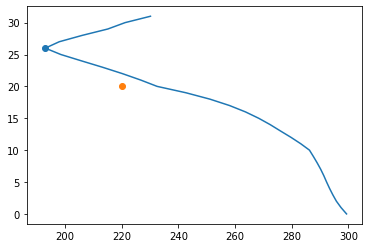

In [211]:
plt.plot(era5_profile,np.arange(len(era5_profile)))
plt.scatter(193,26)
plt.scatter(220,20)

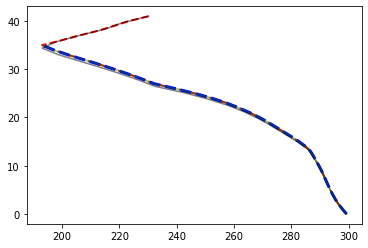

In [210]:
plt.plot(profile_for_emissivities_all,np.arange(len(profile_for_emissivities_all)),c='r',ls='--',lw=2)
plt.plot(profile_for_emissivities_trop,np.arange(len(profile_for_emissivities_trop)),c='b',ls='--',lw=3)
plt.plot(era5_profile,era5_layers,alpha=0.5,c='k')
plt.plot(era5_profile[:era5_N_of_tpause+1],era5_layers_to_tpause,alpha=0.5,c='g')
plt.show()

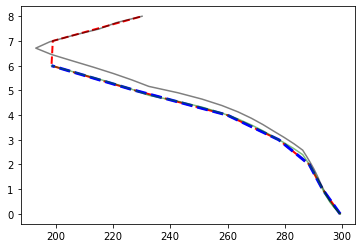

In [55]:
plt.plot(profile_for_emissivities_all,np.arange(len(profile_for_emissivities_all)),c='r',ls='--',lw=2)
plt.plot(profile_for_emissivities_trop,np.arange(len(profile_for_emissivities_trop)),c='b',ls='--',lw=3)
plt.plot(era5_profile,era5_layers,alpha=0.5,c='k')
plt.plot(era5_profile[:era5_N_of_tpause],era5_layers_to_tpause,alpha=0.5,c='g')
plt.show()

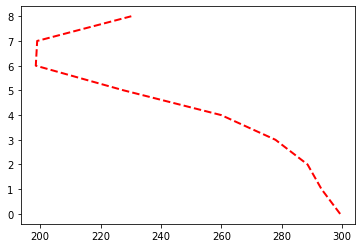

In [13]:
# def get_temps(self, calc_button):
def get_temps(self):
        """
        Query whether track button has been toggled, and calculate the radiation matrix before plotting.
        
        """
#         if self.calc_button.value is True:
        dummy = True
        if dummy is True: ## TEMPORARY
            
            # Create some random emissivities to use, surface emissivity is always one, no emissivity should be zero
            emmisivities = np.repeat(.05,self.N+1)
            emmisivities[0] = 1
            
            # Now get our emissivity Matrix
            R_up_matrix = utils.R_up_matrix(self.N, emmisivities)
            total_emissivity_matrix = utils.emissivity_matrix(R_up_matrix, emmisivities)

            # We also need our forcings vector
            insolation = (self.S0/4)*(1 - self.albedo)
            upward_heatflux = utils.vertical_heat_flux_profile(self.N, self.heatflux, 'exponential')
            
            forcings = utils.forcings_vector(self.N, insolation, upward_heatflux)
            
           

            # Now find the temperature vector using the emissivity matrix and the forcings
            temperature_vector = utils.temperature(total_emissivity_matrix, forcings)


            fig, axs = plt.subplots(1,3, figsize=(12,6))

            # Emissivities plot
            axs[0].plot(emmisivities, range(0, self.N+1), color='black')
            axs[0].set_ylabel('Layer number (n)')
            axs[0].set_xlabel('Emissivity')
            axs[0].set_ylim(0,self.N+1)

            axs[1].set_xlabel('Vertical Heat Flux (W/$m^2$)')
            axs[1].plot(upward_heatflux, range(0, self.N+1), color='dodgerblue')
            axs[1].set_ylim(0,self.N+1)

            axs[2].plot(temperature_vector, range(0, self.N+1), color='firebrick', linewidth=3)
            axs[2].set_xlabel('Temperature ($\degree$K)')
            axs[2].set_ylim(0,self.N+1)
            
#             self.calc_button.value = False

1.0


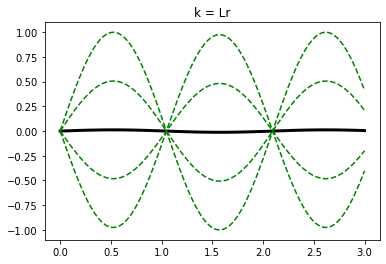

In [272]:
xx = np.linspace(0,3,100)
# Lr = (9.81*1/(10e-4)**2)**1/2
Lr = 1/5
Lr = 3
k = 3
print(Lr/k)

eta1 = ((1 + ((Lr*k)**2)*(1)) / (1 + (Lr*k)**2)) * np.sin(k*xx)
eta15 = ((1 + ((Lr*k)**2)*(1/2)) / (1 + (Lr*k)**2)) * np.sin(k*xx)
eta2 = ((1 + ((Lr*k)**2)*(0)) / (1 + (Lr*k)**2)) * np.sin(k*xx)
eta3 = ((1 + ((Lr*k)**2)*(-1)) / (1 + (Lr*k)**2)) * np.sin(k*xx)
eta35 = ((1 + ((Lr*k)**2)*(-1/2)) / (1 + (Lr*k)**2)) * np.sin(k*xx)
plt.plot(xx,eta2,lw=3,c='k')
plt.plot(xx,eta1,ls='--',c='g')
plt.plot(xx,eta15,ls='--',c='g')
plt.plot(xx,eta35,ls='--',c='g')
plt.plot(xx,eta3,ls='--',c='g')
# plt.xlim(0,100)

# plt.title('k > Lr')
plt.title('k = Lr')
plt.show()

6 2.0


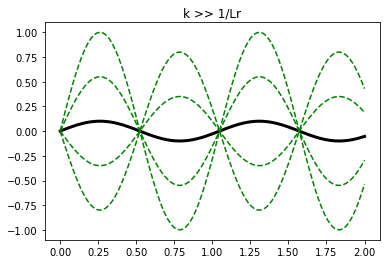

In [352]:
xx = np.linspace(0,2,100)
# Lr = (9.81*1/(10e-4)**2)**1/2
Lr = 1/2
k = 6
print(k,1/Lr)

eta1 = ((1 + ((Lr*k)**2)*(1)) / (1 + (Lr*k)**2)) * np.sin(k*xx)
eta15 = ((1 + ((Lr*k)**2)*(1/2)) / (1 + (Lr*k)**2)) * np.sin(k*xx)
eta2 = ((1 + ((Lr*k)**2)*(0)) / (1 + (Lr*k)**2)) * np.sin(k*xx)
eta3 = ((1 + ((Lr*k)**2)*(-1)) / (1 + (Lr*k)**2)) * np.sin(k*xx)
eta35 = ((1 + ((Lr*k)**2)*(-1/2)) / (1 + (Lr*k)**2)) * np.sin(k*xx)
plt.plot(xx,eta2,lw=3,c='k')
plt.plot(xx,eta1,ls='--',c='g')
plt.plot(xx,eta15,ls='--',c='g')
plt.plot(xx,eta35,ls='--',c='g')
plt.plot(xx,eta3,ls='--',c='g')
# plt.xlim(0,100)

plt.title('k >> 1/Lr')
# plt.title('k = Lr')
plt.show()

5.0


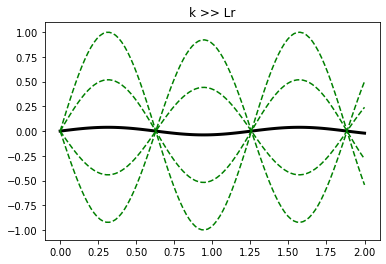

In [332]:
xx = np.linspace(0,2,100)
# Lr = (9.81*1/(10e-4)**2)**1/2
Lr = 1
k = 1/Lr*5
print(Lr*k)

eta1 = ((1 + ((Lr*k)**2)*(1)) / (1 + (Lr*k)**2)) * np.sin(k*xx)
eta15 = ((1 + ((Lr*k)**2)*(1/2)) / (1 + (Lr*k)**2)) * np.sin(k*xx)
eta2 = ((1 + ((Lr*k)**2)*(0)) / (1 + (Lr*k)**2)) * np.sin(k*xx)
eta3 = ((1 + ((Lr*k)**2)*(-1)) / (1 + (Lr*k)**2)) * np.sin(k*xx)
eta35 = ((1 + ((Lr*k)**2)*(-1/2)) / (1 + (Lr*k)**2)) * np.sin(k*xx)
plt.plot(xx,eta2,lw=3,c='k')
plt.plot(xx,eta1,ls='--',c='g')
plt.plot(xx,eta15,ls='--',c='g')
plt.plot(xx,eta35,ls='--',c='g')
plt.plot(xx,eta3,ls='--',c='g')
# plt.xlim(0,100)

plt.title('k >> Lr')
# plt.title('k = Lr')
plt.show()

3 5.0
0.3333333333333333 0.2


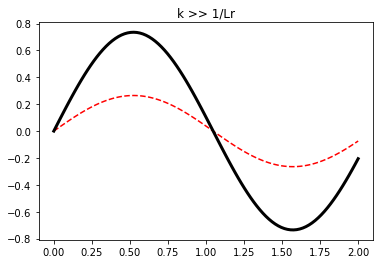

In [369]:
xx = np.linspace(0,2,100)
# Lr = (9.81*1/(10e-4)**2)**1/2

Lr = 1/2
k = 6
plt.title('k >> 1/Lr')

Lr = 1/
k = 3
plt.title('k << 1/Lr')

print(k,1/Lr)
print(1/k,Lr)

eta4 = ((((Lr*k)**2)) / (1 + (Lr*k)**2)) * np.sin(k*xx)
# eta1b = 1 / ((1 + (Lr*k)**2)) * np.sin(k*xx)
# eta2 = ((1 + ((Lr*k)**2)*(0)) / (1 + (Lr*k)**2)) * np.sin(k*xx)
# eta3 = ((1 + ((Lr*k)**2)*(-1)) / (1 + (Lr*k)**2)) * np.sin(k*xx)
# eta35 = ((1 + ((Lr*k)**2)*(-1/2)) / (1 + (Lr*k)**2)) * np.sin(k*xx)
plt.plot(xx,eta4,ls='--',c='r')
plt.plot(xx,eta1b,lw=3,c='k')
# plt.plot(xx,eta15,ls='--',c='g')
# plt.plot(xx,eta35,ls='--',c='g')
# plt.plot(xx,eta3,ls='--',c='g')
# plt.xlim(0,100)

plt.title('k >> 1/Lr')
# plt.title('k = Lr')
plt.show()

6 3.0
0.16666666666666666 0.3333333333333333
6 6.0
0.16666666666666666 0.16666666666666666
6 10.0
0.16666666666666666 0.1


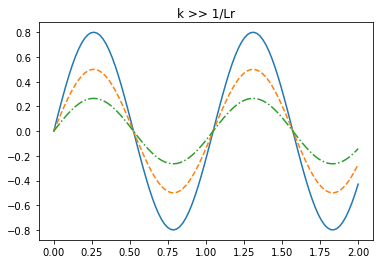

In [384]:
xx = np.linspace(0,2,100)
# Lr = (9.81*1/(10e-4)**2)**1/2

Lr = 1/3
k = 6
plt.title('k >> 1/Lr')

print(k,1/Lr)
print(1/k,Lr)
eta4 = ((((Lr*k)**2)) / (1 + (Lr*k)**2)) * np.sin(k*xx)
plt.plot(xx,eta4,ls='-')

Lr = 1/6
k = 6
plt.title('k >> 1/Lr')

print(k,1/Lr)
print(1/k,Lr)
eta4 = ((((Lr*k)**2)) / (1 + (Lr*k)**2)) * np.sin(k*xx)
plt.plot(xx,eta4,ls='--')


Lr = 1/10
k = 6
print(k,1/Lr)
print(1/k,Lr)
eta4 = ((((Lr*k)**2)) / (1 + (Lr*k)**2)) * np.sin(k*xx)
plt.plot(xx,eta4,ls='-.')

plt.show()